In [ ]:
import degirum as dg
import degirum_tools

# Choose the model name 
face_det_model_name = "scrfd_10g--640x640_quant_hailort_hailo8l_1"
# face_det_model_name = "scrfd_2.5g--640x640_quant_hailort_hailo8l_1"
# face_det_model_name = "scrfd_500m--640x640_quant_hailort_hailo8l_1"
# face_det_model_name = "yolov8n_relu6_widerface_kpts--640x640_quant_hailort_hailo8l_1"
face_det_model_name = "retinaface_mobilenet--736x1280_quant_hailort_hailo8l_1"

# Specify the inference host address
inference_host_address = "@cloud"  # Use "@cloud" for cloud inference
# inference_host_address = "@local"  # Use "@local" for local inference

# Specify the zoo_url
zoo_url = "degirum/models_hailort"
# zoo_url = "<path to local folder>"  # For local model files

# Specify the image source
image_source = "../assets/Friends1.jpg"

# Set the token for accessing the inference service
token = degirum_tools.get_token()
# token = ''  # Leave empty for local inference

# Load the face detection model
face_det_model = dg.load_model(
    model_name=face_det_model_name,
    inference_host_address=inference_host_address,
    zoo_url=zoo_url,
    token=token, 
    overlay_color=(0, 255, 0)  # Green color for bounding boxes
)

# Run the inference
detected_faces = face_det_model(image_source)
print(detected_faces)


In [2]:
import matplotlib.pyplot as plt
def display_images(images, title="Images", figsize=(15, 5)):
    """
    Display a list of images in a single row using Matplotlib.

    Parameters:
    - images (list): List of images (NumPy arrays) to display.
    - title (str): Title for the plot.
    - figsize (tuple): Size of the figure.
    """
    num_images = len(images)
    fig, axes = plt.subplots(1, num_images, figsize=figsize)
    if num_images == 1:
        axes = [axes]  # Make it iterable for a single image
    for ax, image in zip(axes, images):
        image_rgb = image[:, :, ::-1]  # Convert BGR to RGB
        ax.imshow(image_rgb)
        ax.axis('off')
    fig.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()


In [ ]:
display_images([detected_faces.image_overlay], title="Face Detection Result")

In [ ]:
# Lists to store cropped and aligned faces
cropped_faces = []

# Process each detection result
for face in detected_faces.results:
    # Extract bounding box (assumed in [x1, y1, x2, y2] format)
    x1, y1, x2, y2 = map(int, face["bbox"])  # Convert bbox coordinates to integers
    cropped_face = detected_faces.image[y1:y2, x1:x2]  # Crop the face from the image
    cropped_faces.append(cropped_face)

# Display cropped faces
display_images(cropped_faces, title="Cropped Faces", figsize=(10, 5))

In [5]:
import numpy as np
import cv2

def align_and_crop(img, landmarks, image_size=112):
    """
    Align and crop the face from the image based on the given landmarks.

    Args:
        img (np.ndarray): The full image (not the cropped bounding box). This image will be transformed.
        landmarks (List[np.ndarray]): List of 5 keypoints (landmarks) as (x, y) coordinates. These keypoints typically include the eyes, nose, and mouth.
        image_size (int, optional): The size to which the image should be resized. Defaults to 112. It is typically either 112 or 128 for face recognition models.

    Returns:
        Tuple[np.ndarray, np.ndarray]: The aligned face image and the transformation matrix.
    """
    # Define the reference keypoints used in ArcFace model, based on a typical facial landmark set.
    _arcface_ref_kps = np.array(
        [
            [38.2946, 51.6963],  # Left eye
            [73.5318, 51.5014],  # Right eye
            [56.0252, 71.7366],  # Nose
            [41.5493, 92.3655],  # Left mouth corner
            [70.7299, 92.2041],  # Right mouth corner
        ],
        dtype=np.float32,
    )

    # Ensure the input landmarks have exactly 5 points (as expected for face alignment)
    assert len(landmarks) == 5

    # Validate that image_size is divisible by either 112 or 128 (common image sizes for face recognition models)
    assert image_size % 112 == 0 or image_size % 128 == 0

    # Adjust the scaling factor (ratio) based on the desired image size (112 or 128)
    if image_size % 112 == 0:
        ratio = float(image_size) / 112.0
        diff_x = 0  # No horizontal shift for 112 scaling
    else:
        ratio = float(image_size) / 128.0
        diff_x = 8.0 * ratio  # Horizontal shift for 128 scaling

    # Apply the scaling and shifting to the reference keypoints
    dst = _arcface_ref_kps * ratio
    dst[:, 0] += diff_x  # Apply the horizontal shift

    # Estimate the similarity transformation matrix to align the landmarks with the reference keypoints
    M, inliers = cv2.estimateAffinePartial2D(np.array(landmarks), dst, ransacReprojThreshold=1000)
    assert np.all(inliers == True)

    # Apply the affine transformation to the input image to align the face
    aligned_img = cv2.warpAffine(img, M, (image_size, image_size), borderValue=0.0)

    return aligned_img, M


In [ ]:
# Lists to store aligned faces
aligned_faces = []

# Process each detection result
for face in detected_faces.results:
    # Extract landmarks and align the face
    landmarks = [landmark["landmark"] for landmark in face["landmarks"]]
    aligned_face, _ = align_and_crop(detected_faces.image, landmarks)  # Align and crop face
    aligned_faces.append(aligned_face)

# Display aligned faces
display_images(aligned_faces, title="Aligned Faces", figsize=(10, 5))   


In [7]:
# Face recognition model name
face_rec_model_name = "arcface_mobilefacenet--112x112_quant_hailort_hailo8l_1"

# Load the face recognition model
face_rec_model = dg.load_model(
    model_name=face_rec_model_name,
    inference_host_address=inference_host_address,
    zoo_url=zoo_url,
    token=token
)

# Process each detected face
for face in detected_faces.results:
    # Extract landmarks and align the face
    landmarks = [landmark["landmark"] for landmark in face["landmarks"]]
    aligned_face, _ = align_and_crop(detected_faces.image, landmarks)  # Align and crop face
    face_embedding = face_rec_model(aligned_face).results[0]["data"][0]
    

In [8]:
from lancedb.pydantic import LanceModel, Vector
import uuid
import numpy as np
from typing import List, Dict

class FaceRecognitionSchema(LanceModel):
    id: str  # Unique identifier for each entry
    vector: Vector(512)  # Face embeddings, fixed size of 512
    entity_name: str  # Name of the entity

    @classmethod
    def prepare_face_records(cls, face_embeddings: List[Dict], entity_name: str) -> List['FaceRecognitionSchema']:
        """
        Converts a list of face detection results to a list of FaceRecognitionSchema instances.

        Args:
            face_embeddings (List[Dict]): List of face embeddings.
            entity_name (str): Name of the entity.

        Returns:
            List[FaceRecognitionSchema]: List of formatted instances.
        """
        if not face_embeddings:
            return []

        formatted_records = []
        for embedding in face_embeddings:
            formatted_records.append(
                cls(
                    id=str(uuid.uuid4()),  # Generate a unique ID
                    vector=np.array(embedding, dtype=np.float32),  # Convert embedding to float32 numpy array
                    entity_name=entity_name
                )
            )
        return formatted_records


In [9]:
from pathlib import Path
import logging
from typing import Any

# Configure logging for better output control
logging.basicConfig(level=logging.WARNING, format="%(asctime)s - %(levelname)s - %(message)s")

def populate_database_from_images(
    input_path: str,
    face_det_model: Any,
    face_rec_model: Any,
    tbl: Any  # LanceDB table object
) -> None:
    """
    Iterates over images in a directory, detects faces, generates embeddings,
    and populates the database with face records.

    Args:
        input_path (str): Path to the directory containing image files.
        face_det_model (Any): Face detection and keypoints model.
        face_rec_model (Any): Face re-identification model.
        tbl (Any): LanceDB table object.
    """
    path = Path(input_path)
    num_entities = 0  # Counter for the number of entities added to the database

    # Find all image files in the directory and subdirectories
    image_files = [str(file) for file in path.rglob("*") if file.suffix.lower() in (".png", ".jpg", ".jpeg")]
    identities = [file.stem.split("_")[0] for file in path.rglob("*") if file.suffix.lower() in (".png", ".jpg", ".jpeg")]
    print(image_files, identities)
    if not image_files:
        logging.warning(f"No image files found in {input_path}.")
        return

    for identity, detected_faces in zip(identities, face_det_model.predict_batch(image_files)):
        try:
            print(identity, detected_faces.info)
            # Count number of detected faces
            num_faces = len(detected_faces.results)

            # Skip images with more than one face
            if num_faces > 1:
                logging.warning(f"Skipped {detected_faces.info} as it contains more than one face ({num_faces} faces detected).")
                continue
            elif num_faces == 0:
                logging.warning(f"Skipped {detected_faces.info} as no faces were detected.")
                continue

            # Process the single detected face
            result = detected_faces.results[0]

            # Generate face embedding
            aligned_img, _ = align_and_crop(detected_faces.image, [landmark["landmark"] for landmark in result["landmarks"]])
            face_embedding = face_rec_model(aligned_img).results[0]["data"][0]
            
            # Prepare records for the database
            records = FaceRecognitionSchema.prepare_face_records([face_embedding], identity)

            # Add records to the database if valid
            if records:
                tbl.add(data=records)
                num_entities += len(records)
            else:
                logging.warning(f"No valid records generated for {detected_faces.info}.")

        except Exception as e:
            logging.error(f"Error processing {file}: {e}", exc_info=True)

    # Log summary
    logging.info(f"Successfully added {num_entities} entities to the database table.")
    total_entities = tbl.count_rows()
    logging.info(f"The table now contains {total_entities} entities.")


In [ ]:
import lancedb

# Database and table setup
uri = "../.temp/face_database"
table_name = "face"

# Path to the directory containing the sample dataset for indexing.
input_path = "../assets/Friends_dataset"

# Connect to the database
db = lancedb.connect(uri=uri)

# Initialize the table
if table_name not in db.table_names():
    tbl = db.create_table(table_name, schema=FaceRecognitionSchema)
else:
    tbl = db.open_table(table_name)
    schema_fields = [field.name for field in tbl.schema]
    if schema_fields != list(FaceRecognitionSchema.model_fields.keys()):
        raise RuntimeError(f"Table {table_name} has a different schema.")

# Process images and populate the database
populate_database_from_images(
    input_path=input_path,
    face_det_model=face_det_model,
    face_rec_model=face_rec_model,
    tbl=tbl
)


In [11]:
from typing import List, Any
import numpy as np

def identify_faces(
    embeddings: List[np.ndarray],  # List of NumPy arrays representing face embeddings
    tbl: Any,                      # The database or table object supporting the search method
    field_name: str,               # Name of the vector column in the database
    metric_type: str,              # Metric type for distance calculation (e.g., "cosine", "euclidean")
    top_k: int,                    # Number of top results to fetch from the database
    threshold: float = 0.3         # Distance threshold for assigning labels
) -> List[str]:
    """
    Identifies faces by searching for the nearest embeddings in the database and assigning labels.

    Args:
        embeddings (List[np.ndarray]): List of NumPy arrays representing face embeddings.
        tbl (Any): Database or table object supporting search functionality.
        field_name (str): Name of the vector column to search against.
        metric_type (str): Distance metric to use (e.g., "cosine", "euclidean").
        top_k (int): Number of top results to retrieve.
        threshold (float, optional): Minimum similarity score for assigning a known label. Defaults to 0.3.

    Returns:
        List[str]: List of labels for the provided embeddings. Returns "Unknown" for embeddings below the threshold.
    """
    identities = []  # List to store the assigned labels
    similarity_scores = []  # List to store the similarity scores

    for embedding in embeddings:
        # Perform database search
        search_result = (
            tbl.search(
                embedding,
                vector_column_name=field_name
            )
            .metric(metric_type)
            .limit(top_k)
            .to_list()
        )

        # Check if search_result has any entries
        if not search_result:
            identities.append("Unknown")
            continue

        # Calculate the similarity score
        similarity_score = round(1 - search_result[0]["_distance"], 2)

        # Assign a label based on the similarity threshold
        identity = search_result[0]["entity_name"] if similarity_score >= threshold else "Unknown"

        # Append the label to the results list
        identities.append(identity)
        similarity_scores.append(similarity_score)
    return identities, similarity_scores


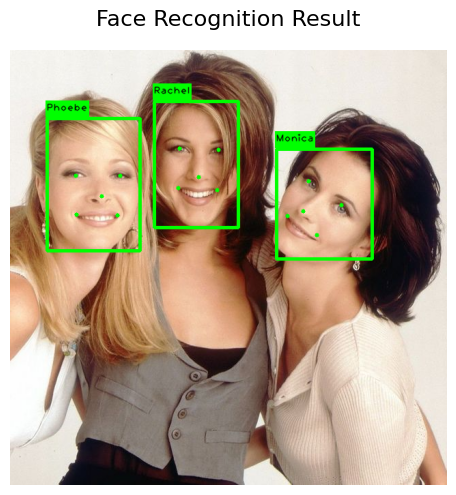

In [27]:
import lancedb
# database related parameters
top_k = 1
field_name = "vector"
metric_type = "cosine"

# Database and table parameters
uri = "../.temp/face_database"
table_name = "face"

# Connect to the database
db = lancedb.connect(uri=uri)
tbl = db.open_table(table_name)

# check the schema of the table to ensure it matches the expected schema
schema_fields = [field.name for field in tbl.schema]
if schema_fields != list(FaceRecognitionSchema.model_fields.keys()):
    raise RuntimeError(f"Table {table_name} has a different schema.")

# image source
image_source = "../assets/Friends1.jpg"

# run the face detection model
face_det_model.overlay_show_probabilities=False
detected_faces = face_det_model(image_source) 

# Process the detected faces: align, crop, extract embeddings and find the identity
if detected_faces.results:
    for face in detected_faces.results:
        landmarks = [landmark["landmark"] for landmark in face["landmarks"]]
        aligned_face, _ = align_and_crop(detected_faces.image, landmarks)
        face_embedding = face_rec_model(aligned_face).results[0]["data"][0]
        identities, similarity_scores = identify_faces([face_embedding], tbl, field_name, metric_type, top_k)
        # replace the label and score in the result with the identity and similarity score
        face["label"] = identities[0]  # Assign the first label
        face["score"] = similarity_scores[0]  # Assign the first score

display_images([detected_faces.image_overlay], title="Face Recognition Result", figsize=(10, 5)) 

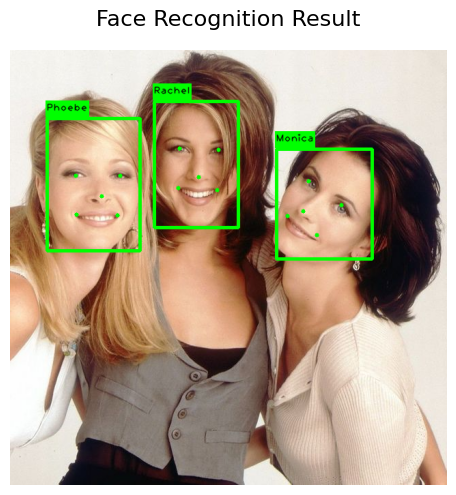

In [31]:
image_source = "../assets/Friends1.jpg"
detected_faces = face_det_model(image_source) 
aligned_faces = []
if detected_faces.results:
    for face in detected_faces.results:
        landmarks = [landmark["landmark"] for landmark in face["landmarks"]]
        aligned_face, _ = align_and_crop(detected_faces.image, landmarks)
        aligned_faces.append(aligned_face)    
    
    # Run batch predict on aligned faces, find identity, assign labels and scores to each detection
    for face, face_embedding in zip(detected_faces.results, face_rec_model.predict_batch(aligned_faces)):
        embedding = face_embedding.results[0]["data"][0]  # Extract embedding
        identities, similarity_scores = identify_faces([embedding], tbl, field_name, metric_type, top_k)
        face["label"] = identities[0]  # Assign the first label
        face["score"] = similarity_scores[0]  # Assign the first score

display_images([detected_faces.image_overlay], title="Face Recognition Result", figsize=(10, 5))           

In [29]:
video_source = 1

with degirum_tools.Display("AI Camera") as output_display:
    for detected_faces in degirum_tools.predict_stream(face_det_model, video_source):
        if detected_faces.results:
            aligned_faces = []
            for face in detected_faces.results:
                landmarks = [landmark["landmark"] for landmark in face["landmarks"]]
                aligned_face, _ = align_and_crop(detected_faces.image, landmarks)
                aligned_faces.append(aligned_face)    
            
            # Run batch predict on aligned faces, find identity, assign labels and scores to each detection
            for face, face_embedding in zip(detected_faces.results, face_rec_model.predict_batch(aligned_faces)):
                embedding = face_embedding.results[0]["data"][0]  # Extract embedding
                identities, similarity_scores = identify_faces([embedding], tbl, field_name, metric_type, top_k)
                face["label"] = identities[0]  # Assign the first label
                face["score"] = similarity_scores[0]  # Assign the first score
        output_display.show(detected_faces.image_overlay)
# display_images([detected_faces.image_overlay], title="Face Recognition Result", figsize=(10, 10))  